### This notebook is to look at delirium data closely, do some EDA.

## Imports

In [1]:
import os
import re
import sys
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlalchemy
from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection
from sqlalchemy import desc, func, select
from sqlalchemy.sql.expression import and_, or_

from cyclops.query import gemini
from cyclops.processors.column_names import AGE, SEX, ENCOUNTER_ID, HOSPITAL_ID, DIAGNOSIS_CODE, ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP, EVENT_NAME
from cyclops.processor import Aggregator, Imputer, featurize
from cyclops.processors.utils import gather_columns

2022-04-21 12:37:38,535 INFO cyclops.config  - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:39,095 INFO cyclops.query.utils - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:39,309 INFO cyclops.utils.profile - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:39,935 INFO cyclops.orm     - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:39,944 INFO cyclops.query.interface - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:40,521 INFO cyclops.orm     - Database setup, ready to run queries!
2022-04-21 12:37:40,731 INFO cyclops.processors.utils - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:40,851 INFO cyclops.processors.aggregate - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-21 12:37:40,907 INFO cyclops.processors.diagnoses - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.lo

## String constants

In [2]:
DELIRIUM_LABEL = "del_present"

DISCHARGE_DISPOSITION = "discharge_disposition"
ADMIT_DATE_TIME = "admit_date_time"
DISCHARGE_DATE_TIME = "discharge_date_time"
MEDICATION_NAME = "medication_name"
UNIQUE_MEDS_NAMES = "unique_meds_names"
UNIQUE_MEDS_COUNTS = "unique_meds_counts"

REPORT_SAVE_PATH = "/mnt/nfs/project/delirium/_reports"

## Plot utility functions

In [3]:
def setup_plot(
    plot_handle: matplotlib.axes.SubplotBase,
    title: str,
    xlabel: str,
    ylabel: str,
    legend: list,
):
    """Setup plot.

    Parameters
    ----------
    plot_handle: matplotlib.axes.SubplotBase
        Subplot handle.
    title: str
        Title of plot.
    xlabel: str
        Label for x-axis.
    ylabel: str
        Label for y-axis.
    legend: list
        Legend for different sub-groups.
    """
    plot_handle.title.set_text(title)
    plot_handle.set_xlabel(xlabel, fontsize=20)
    plot_handle.set_ylabel(ylabel, fontsize=20)
    plot_handle.legend(legend, loc=1)


def set_bars_color(bars: matplotlib.container.BarContainer, color: str):
    """Set color attribute for bars in bar plots.

    Parameters
    ----------
    bars: matplotlib.container.BarContainer
        Bars.
    color: str
        Color.
    """
    for bar in bars:
        bar.set_color(color)

## Delirium data distribution

2022-04-21 12:37:42,294 INFO cyclops.orm     - Query returned successfully!
2022-04-21 12:37:42,297 INFO cyclops.utils.profile - Finished executing function run_query in 0.240138 s


Mean Age: Delirium present: 76.57520325203252, No delirium: 66.1254819488258


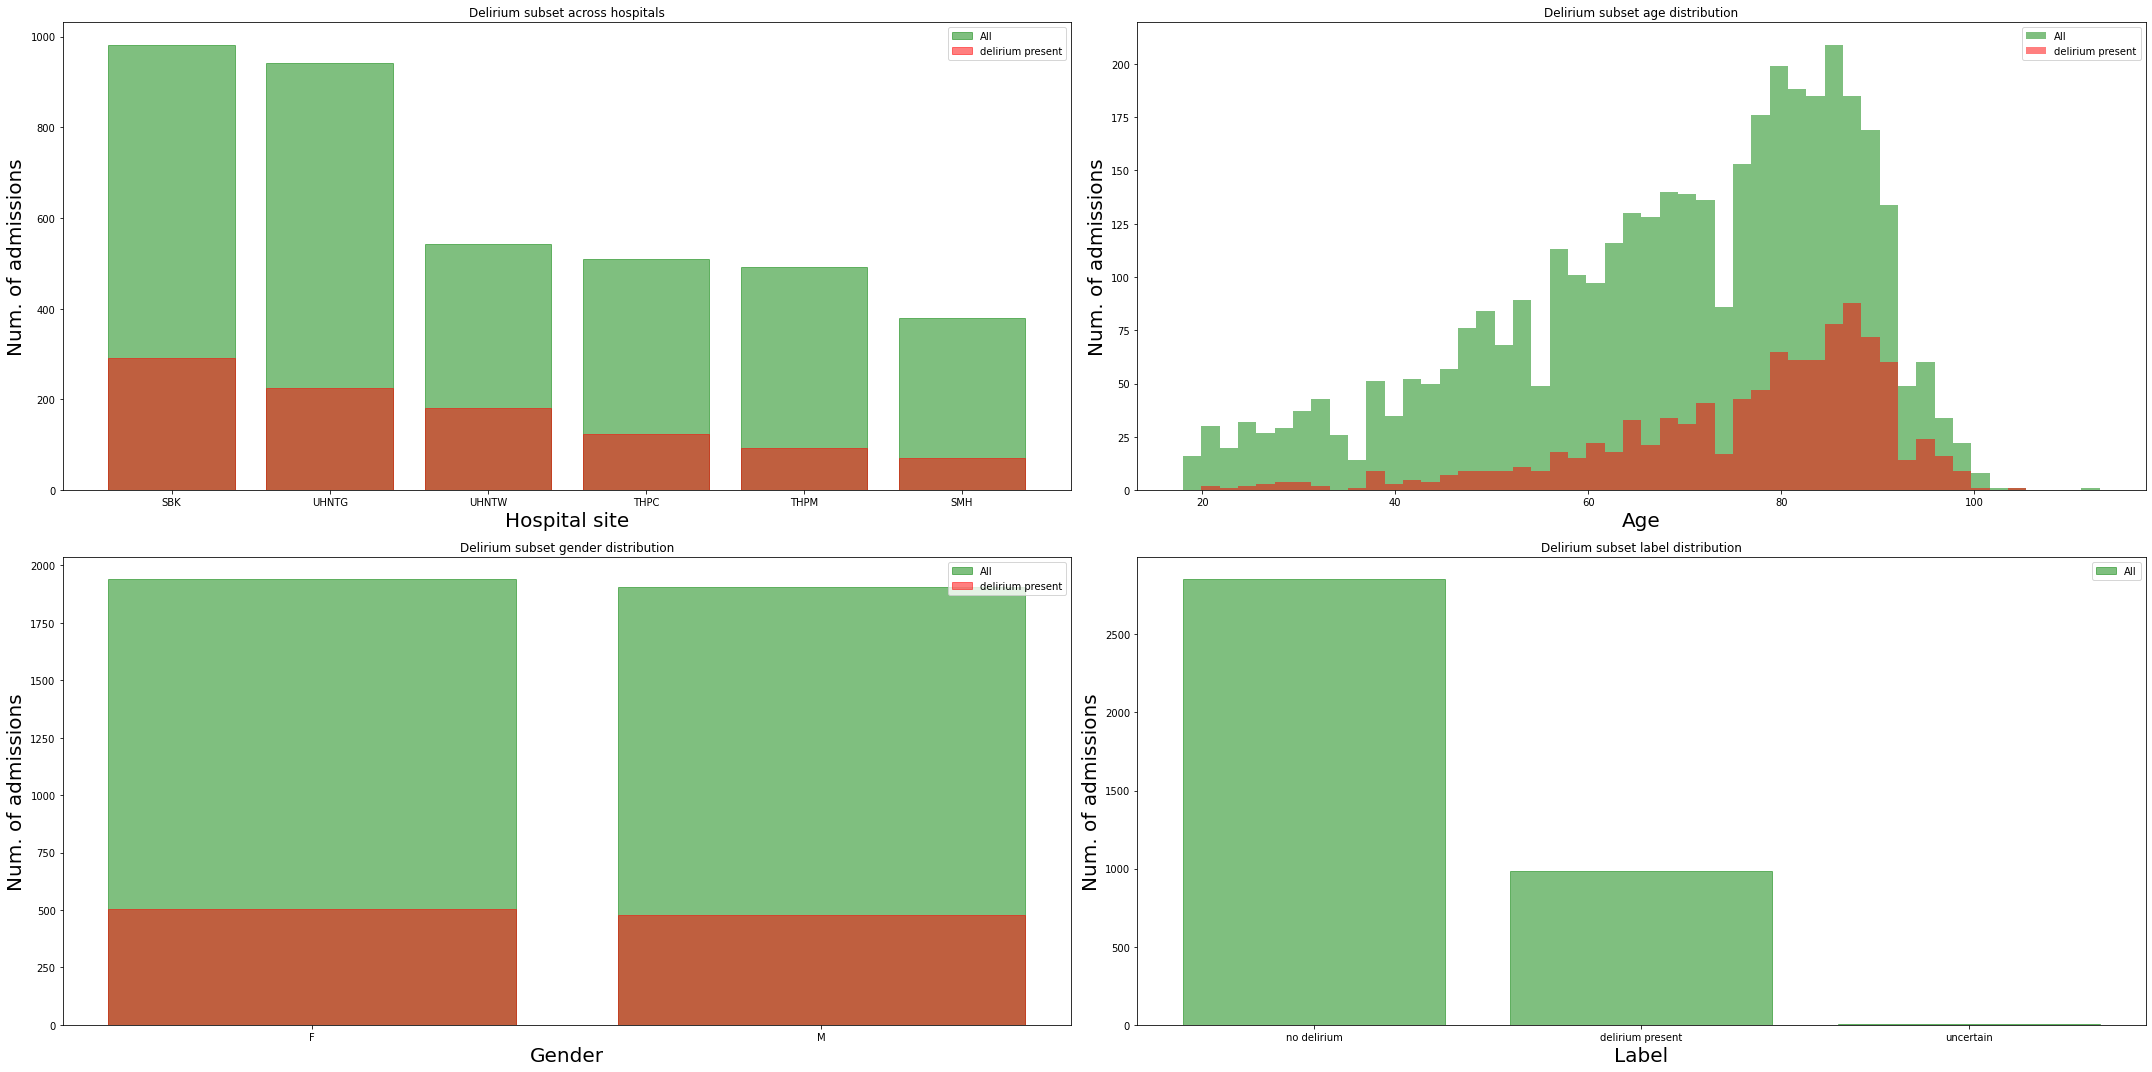

In [4]:
delirium_patients = gemini.patients(delirium_cohort=True)
admin_data = delirium_patients.run()
admin_data_pos = admin_data.loc[admin_data[DELIRIUM_LABEL] == 1]
admin_data_neg = admin_data.loc[admin_data[DELIRIUM_LABEL] == 2]

fig, axs = plt.subplots(2, 2, figsize=(30, 15), tight_layout=True)

# Across hospitals.
hosp_counts = list(admin_data[HOSPITAL_ID].value_counts())
hospitals = list(admin_data[HOSPITAL_ID].unique())
hosp_counts_pos = list(admin_data_pos[HOSPITAL_ID].value_counts())

hosp_bars = axs[0][0].bar(hospitals, hosp_counts, alpha=0.5)
set_bars_color(hosp_bars, "g")
hosp_bars_pos = axs[0][0].bar(hospitals, hosp_counts_pos, alpha=0.5)
set_bars_color(hosp_bars_pos, "r")
setup_plot(
    axs[0][0],
    "Delirium subset across hospitals",
    "Hospital site",
    "Num. of admissions",
    ["All", "delirium present"],
)

# Across age.
ages = admin_data[AGE]
ages_pos = admin_data_pos[AGE]
ages_neg = admin_data_neg[AGE]
print(
    f"Mean Age: Delirium present: {np.array(ages_pos).mean()}, No delirium: {np.array(ages_neg).mean()}"
)

(_, bins, _) = axs[0][1].hist(ages, bins=50, alpha=0.5, color="g")
axs[0][1].hist(ages_pos, bins=bins, alpha=0.5, color="r")
setup_plot(
    axs[0][1],
    "Delirium subset age distribution",
    "Age",
    "Num. of admissions",
    ["All", "delirium present"],
)

# Across gender.
genders = list(admin_data[SEX].unique())
gender_counts = list(admin_data[SEX].value_counts())
gender_counts_pos = list(admin_data_pos[SEX].value_counts())

gender_bars = axs[1][0].bar(genders, gender_counts, alpha=0.5)
set_bars_color(gender_bars, "g")
gender_bars_pos = axs[1][0].bar(genders, gender_counts_pos, alpha=0.5)
set_bars_color(gender_bars_pos, "r")
setup_plot(
    axs[1][0],
    "Delirium subset gender distribution",
    "Gender",
    "Num. of admissions",
    ["All", "delirium present"],
)

# Across labels.
DEL_LABEL_MAP = {1: "delirium present", 2: "no delirium", 3: "uncertain"}
label_counts = admin_data[DELIRIUM_LABEL].value_counts().to_dict().values()
labels = admin_data[DELIRIUM_LABEL].value_counts().to_dict().keys()
labels = [DEL_LABEL_MAP[l] for l in labels]

label_bars = axs[1][1].bar(labels, label_counts, alpha=0.5)
set_bars_color(label_bars, "g")
setup_plot(
    axs[1][1],
    "Delirium subset label distribution",
    "Label",
    "Num. of admissions",
    ["All"],
)

plt.show()

## Convert diagnosis codes to ICD 10 trajectories and hence binary features.

In [5]:
delirium_patients = gemini.patients(delirium_cohort=True)
delirium_patients_diagnoses = gemini.diagnoses(patients=delirium_patients)

diagnoses_data = delirium_patients_diagnoses.run()

diagnoses_data = gather_columns(
    diagnoses_data, [ENCOUNTER_ID, AGE, SEX, DIAGNOSIS_CODE]
)
feature_handler = featurize(
    static_data=[diagnoses_data],
    imputer=Imputer(strategy="none"),
    aggregator=Aggregator(),
)

2022-04-21 12:37:44,653 INFO cyclops.orm     - Query returned successfully!
2022-04-21 12:37:44,656 INFO cyclops.utils.profile - Finished executing function run_query in 1.144220 s
2022-04-21 12:37:44,664 INFO cyclops.processors.utils - Processing raw diagnosis codes...
2022-04-21 12:37:44,667 INFO cyclops.processors.utils - # samples: 31623, # encounters: 3845
2022-04-21 12:37:45,934 INFO cyclops.processors.utils - Grouping ICD codes to trajectories...
2022-04-21 12:37:45,936 INFO cyclops.processors.utils - # samples: 31623, # encounters: 3845
2022-04-21 12:37:45,941 INFO cyclops.processors.diagnoses - # diagnosis features: 20, # encounters: 3845
2022-04-21 12:37:47,792 INFO cyclops.utils.profile - Finished executing function group_diagnosis_codes_to_trajectories in 3.127564 s
2022-04-21 12:37:47,819 INFO cyclops.processors.utils - Gathering static features...
2022-04-21 12:37:47,821 INFO cyclops.processors.utils - # samples: 31623, # encounters: 3845
2022-04-21 12:37:47,823 INFO cycl

## Data quality report (diagnosis codes)

In [6]:
dashboard = Dashboard(tabs=[DataQualityTab()])
column_mapping = ColumnMapping(categorical_features=feature_handler.get_categorical_features())
dashboard.calculate(
    reference_data=feature_handler.features,
    current_data=None,
    column_mapping=column_mapping,
)
dashboard.save(os.path.join(REPORT_SAVE_PATH, "delirium_diagnosis_processed.html"))

## Discharge disposition

Transferred to acute inpatient institution (other acute, psych, etc.): 46
Transferred continuing care (other facility or level of care in same): 711
Transfer other (ambulatory/palliative, addiction/jail, child agency): 20
Discharged to a home setting with support services (senior lodge, attendant care, home care . . .): 874
Discharged home (no external support needed, not incl. nursing homes): 1881
Signed out (leaving against medical advice, AWOL): 57
Died: 256


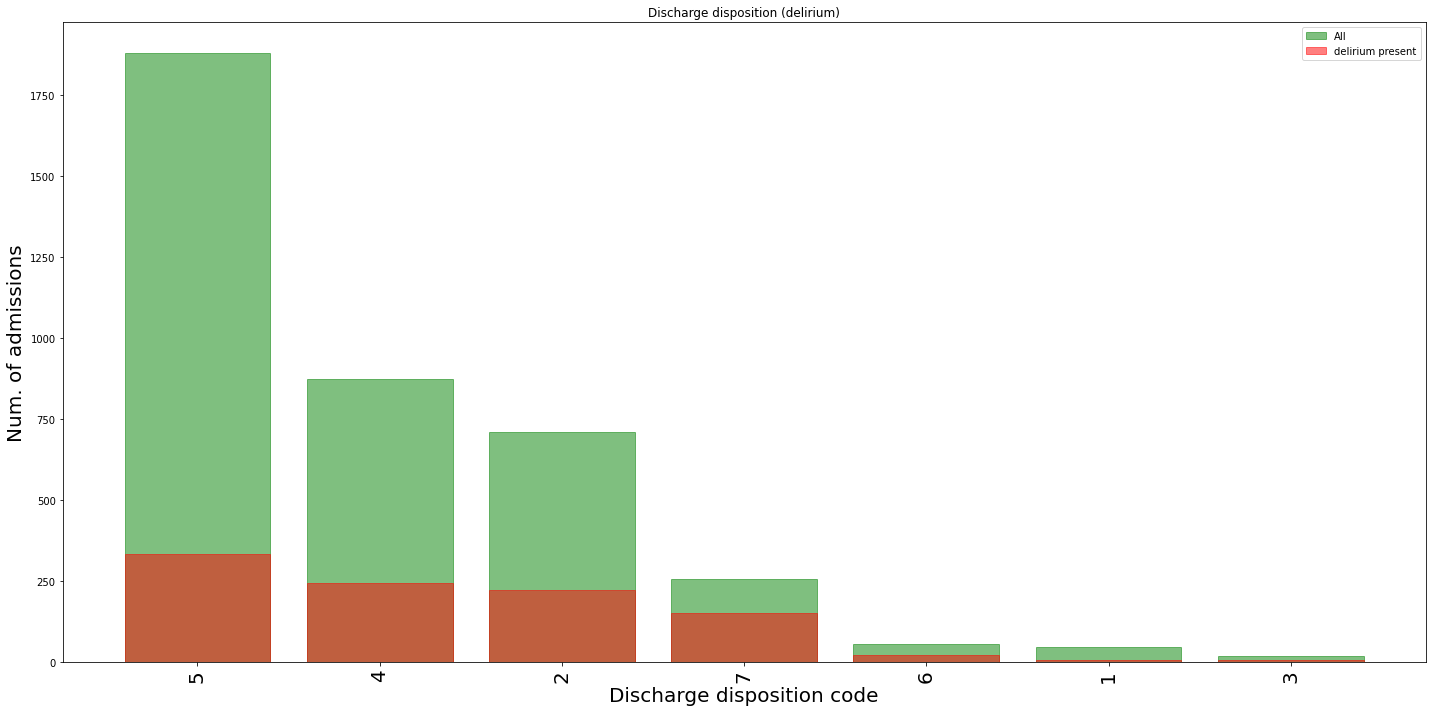

In [7]:
# Longer descriptions taken from CIHI portal
# https://www.cihi.ca/sites/default/files/document/cihi-portal-release-notes-release-13.1-en_en02jpdg.pdf
DISCHARGE_DISPOSITION_MAP = {
    1: "Transferred to acute inpatient institution (other acute, psych, etc.)",
    2: "Transferred continuing care (other facility or level of care in same)",
    3: "Transfer other (ambulatory/palliative, addiction/jail, child agency)",
    4: "Discharged to a home setting with support services (senior lodge, attendant care, home care . . .)",
    5: "Discharged home (no external support needed, not incl. nursing homes)",
    6: "Signed out (leaving against medical advice, AWOL)",
    7: "Died",
}
discharge_disposition_counts = admin_data[DISCHARGE_DISPOSITION].value_counts()
discharge_disposition_counts_pos = admin_data_pos[DISCHARGE_DISPOSITION].value_counts()
for disch_code, meaning in DISCHARGE_DISPOSITION_MAP.items():
    print(f"{meaning}: {discharge_disposition_counts[disch_code]}")

fig, axs = plt.subplots(1, 1, figsize=(20, 10), tight_layout=True)
disch_disp_bars = plt.bar(
    list(range(len(discharge_disposition_counts))),
    discharge_disposition_counts.values,
    alpha=0.5,
)
set_bars_color(disch_disp_bars, "g")
disch_disp_bars_pos = plt.bar(
    list(range(len(discharge_disposition_counts_pos))),
    discharge_disposition_counts_pos.values,
    alpha=0.5,
)
set_bars_color(disch_disp_bars_pos, "r")
axs.set_xticks(
    range(len(discharge_disposition_counts)),
    discharge_disposition_counts.keys(),
    rotation="vertical",
    fontsize=20,
)
setup_plot(
    axs,
    "Discharge disposition (delirium)",
    "Discharge disposition code",
    "Num. of admissions",
    ["All", "delirium present"],
)

plt.show()

# Fraction of encounters with delirium positive label, and disch. dispostion (7) - is significantly higher compared to others.

## Year of care, LOS distribution (delirium subset)

Mean LOS (days): Delirium present: 14.075203252032521, No delirium: 6.058885383806519


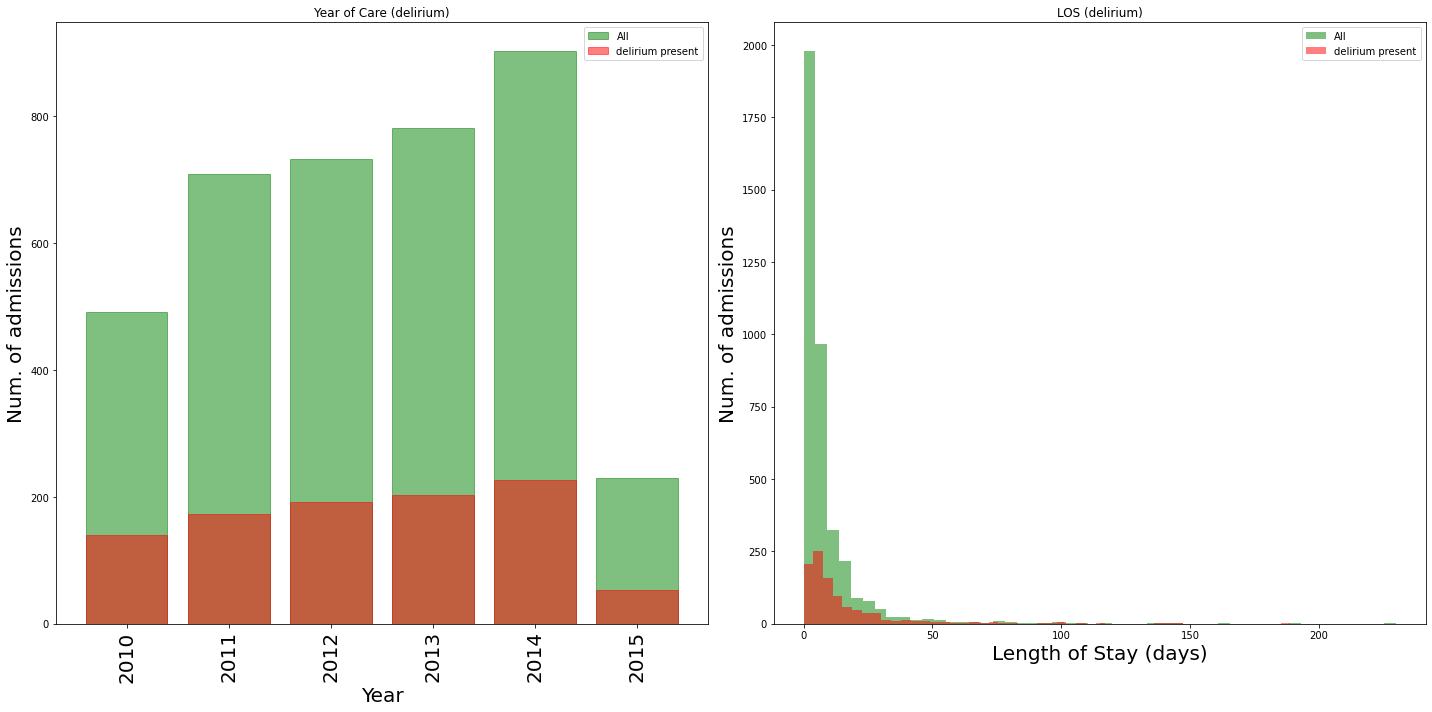

In [8]:
admit_discharge_times = admin_data[[ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP]]
years_counts = admit_discharge_times[ADMIT_TIMESTAMP].dt.year.value_counts().to_dict()
years_counts = OrderedDict(sorted(years_counts.items()))

admit_discharge_times_pos = admin_data_pos[[ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP]]
years_counts_pos = (
    admit_discharge_times_pos[ADMIT_TIMESTAMP].dt.year.value_counts().to_dict()
)
years_counts_pos = OrderedDict(sorted(years_counts_pos.items()))

fig, axs = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
years_bars = axs[0].bar(
    list(range(len(years_counts))), years_counts.values(), alpha=0.5
)
set_bars_color(years_bars, "g")
years_bars_pos = axs[0].bar(
    list(range(len(years_counts_pos))), years_counts_pos.values(), alpha=0.5
)
set_bars_color(years_bars_pos, "r")
axs[0].set_xticks(
    range(len(years_counts)), years_counts.keys(), rotation="vertical", fontsize=20
)
setup_plot(
    axs[0],
    "Year of Care (delirium)",
    "Year",
    "Num. of admissions",
    ["All", "delirium present"],
)

los = (
    admit_discharge_times[DISCHARGE_TIMESTAMP] - admit_discharge_times[ADMIT_TIMESTAMP]
)
los = los.astype("timedelta64[D]")
los_pos = (
    admit_discharge_times_pos[DISCHARGE_TIMESTAMP]
    - admit_discharge_times_pos[ADMIT_TIMESTAMP]
)
los_pos = los_pos.astype("timedelta64[D]")
admit_discharge_times_neg = admin_data_neg[[ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP]]
los_neg = (
    admit_discharge_times_neg[DISCHARGE_TIMESTAMP]
    - admit_discharge_times_neg[ADMIT_TIMESTAMP]
)
los_neg = los_neg.astype("timedelta64[D]")
print(
    f"Mean LOS (days): Delirium present: {np.array(los_pos).mean()}, No delirium: {np.array(los_neg).mean()}"
)
axs[1].hist(los, bins=50, alpha=0.5, color="g")
axs[1].hist(los_pos, bins=50, alpha=0.5, color="r")
setup_plot(
    axs[1],
    "LOS (delirium)",
    "Length of Stay (days)",
    "Num. of admissions",
    ["All", "delirium present"],
)

plt.show()

## Plot distribution of lab tests ordered (delirium subset)

2022-04-21 12:40:14,548 INFO cyclops.orm     - Query returned successfully!
2022-04-21 12:40:14,552 INFO cyclops.utils.profile - Finished executing function run_query in 141.407509 s


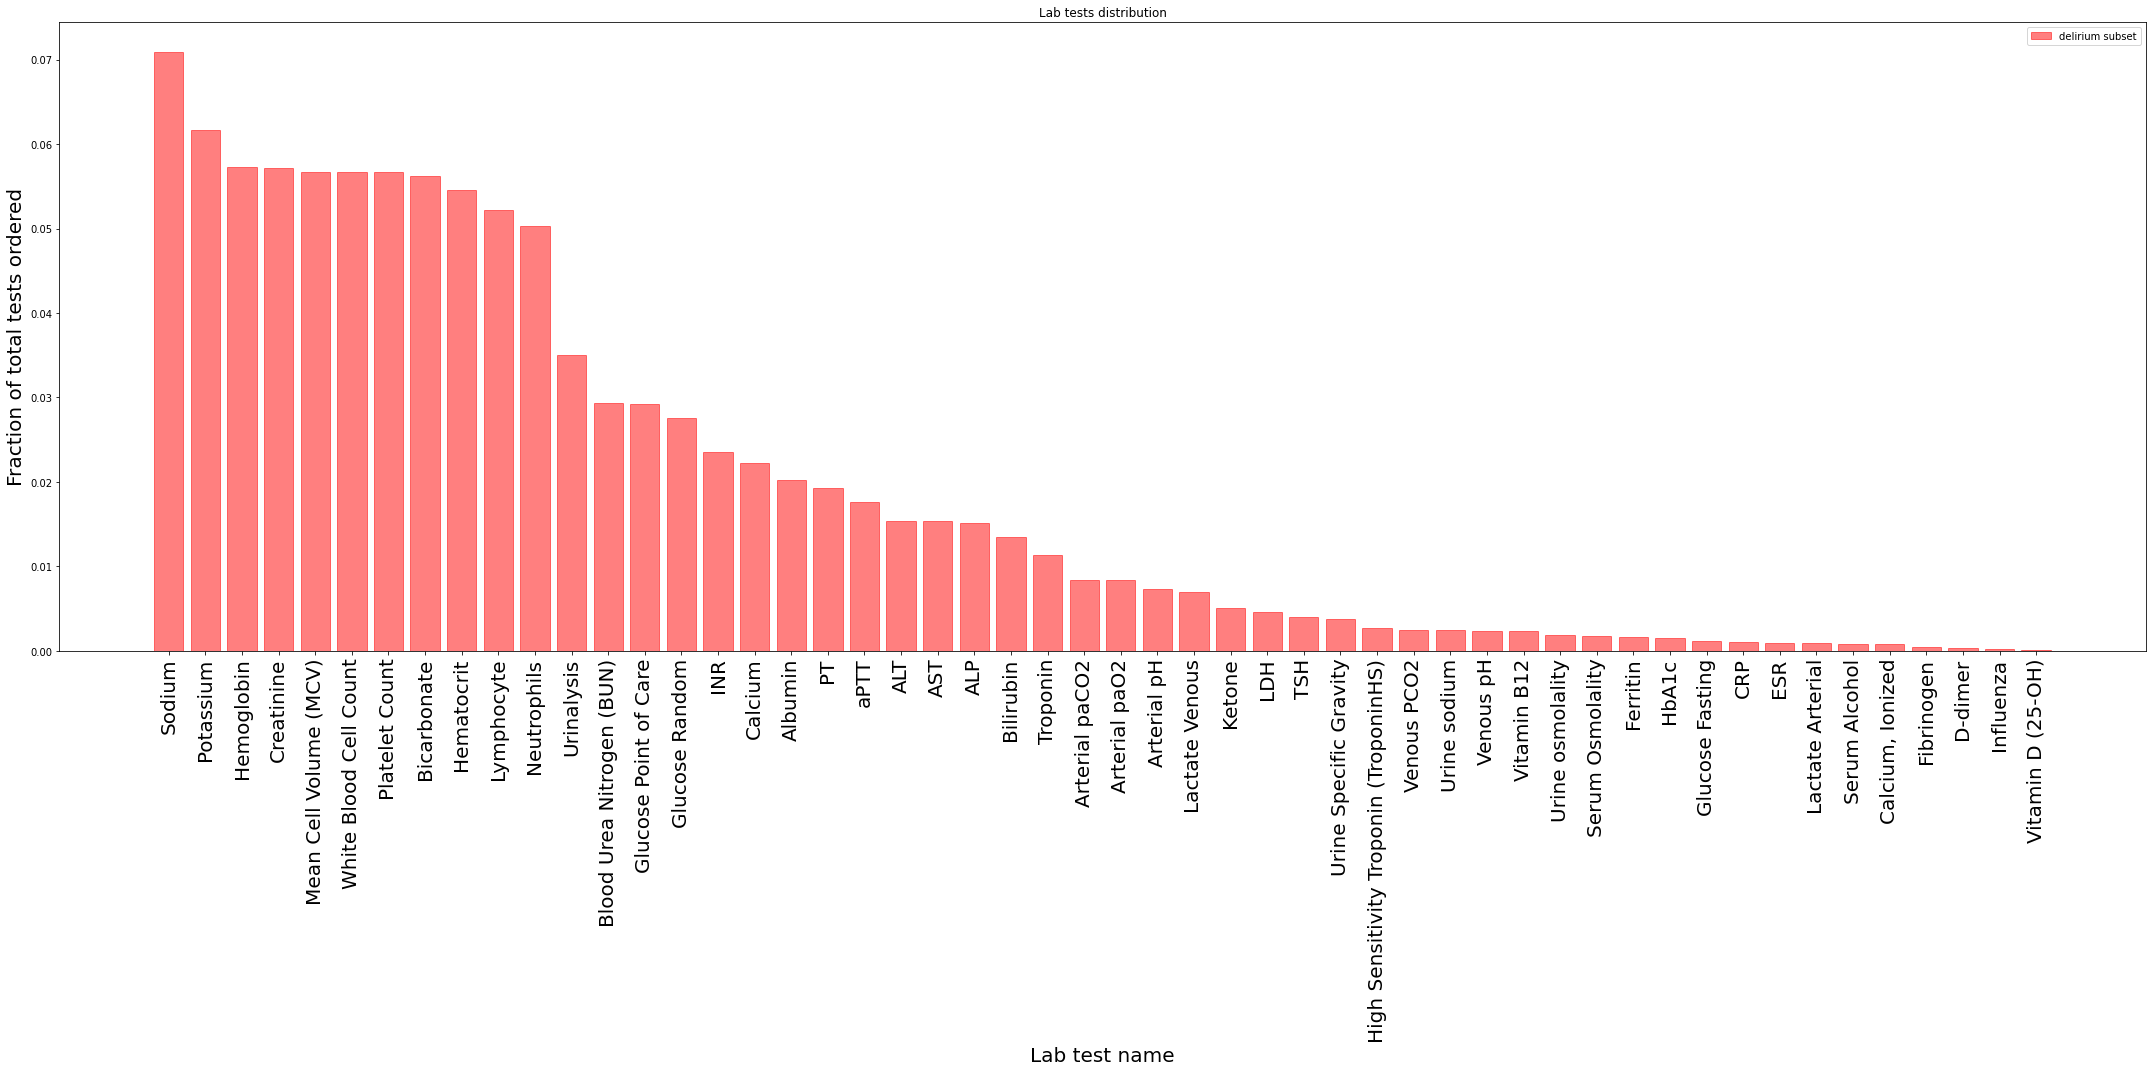

In [9]:
delirium_patients = gemini.patients(delirium_cohort=True)
delirium_patients_labs = gemini.events(patients=delirium_patients, category="lab")
lab_data = delirium_patients_labs.run()

del_lab_names = lab_data[EVENT_NAME].value_counts().keys()
del_lab_counts = lab_data[EVENT_NAME].value_counts().values
del_lab_counts = np.array(del_lab_counts) / sum(del_lab_counts)

fig, axs = plt.subplots(1, 1, figsize=(30, 15), tight_layout=True)
delirum_labs_bars = plt.bar(list(range(len(del_lab_names))), del_lab_counts, alpha=0.5)
set_bars_color(delirum_labs_bars, "r")
axs.set_xticks(
    range(len(delirum_labs_bars)), del_lab_names, rotation="vertical", fontsize=20
)
setup_plot(
    axs,
    "Lab tests distribution",
    "Lab test name",
    "Fraction of total tests ordered",
    ["delirium subset"],
)

plt.show()

## Lab tests distribution across sites (delirium).

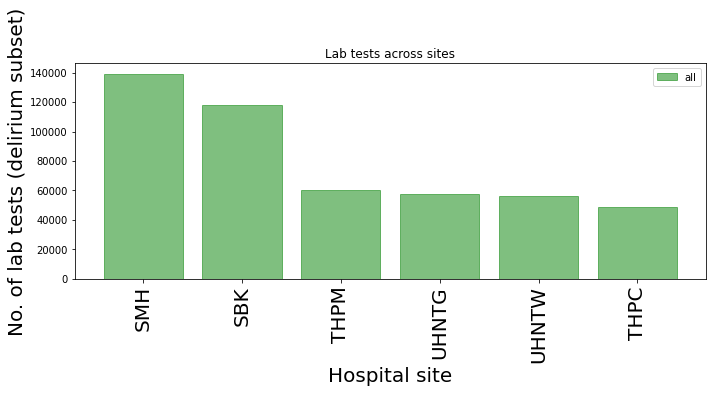

In [10]:
lab_counts_hosp = lab_data[HOSPITAL_ID].value_counts()

fig, axs = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
labs_hosp_bars = plt.bar(
    list(range(len(lab_counts_hosp))), lab_counts_hosp.values, alpha=0.5
)
set_bars_color(labs_hosp_bars, "g")
axs.set_xticks(
    range(len(labs_hosp_bars)), lab_counts_hosp.keys(), rotation="vertical", fontsize=20
)
setup_plot(
    axs,
    "Lab tests across sites",
    "Hospital site",
    "No. of lab tests (delirium subset)",
    ["all"],
)

plt.show()

## Run processor on lab data

In [ ]:
feature_handler = featurize(
    temporal_data=[lab_data],
    imputer=Imputer(strategy="none"),
    aggregator=Aggregator(),
)

2022-04-21 12:40:16,934 INFO cyclops.processors.utils - Cleaning raw event data...
2022-04-21 12:40:16,940 INFO cyclops.processors.utils - # samples: 480093, # encounters: 3837
2022-04-21 12:40:16,942 INFO cyclops.processors.utils - # columns: 51, # encounters: 3837
2022-04-21 12:40:17,541 INFO cyclops.processors.utils - Drop unsupported events...
2022-04-21 12:40:17,548 INFO cyclops.processors.utils - # samples: 480093, # encounters: 3837
2022-04-21 12:40:17,550 INFO cyclops.processors.utils - # columns: 51, # encounters: 3837
2022-04-21 12:40:18,807 INFO cyclops.processors.utils - Remove text in parentheses and normalize lab test names...
2022-04-21 12:40:18,813 INFO cyclops.processors.utils - # samples: 480093, # encounters: 3837
2022-04-21 12:40:18,816 INFO cyclops.processors.utils - # columns: 51, # encounters: 3837
2022-04-21 12:40:21,571 INFO cyclops.processors.utils - Fixing inequalities and removing outlier values...
2022-04-21 12:40:21,580 INFO cyclops.processors.utils - # sa

## Data quality report (labs)

In [ ]:
dashboard = Dashboard(tabs=[DataQualityTab()])
column_mapping = ColumnMapping(
    numerical_features=feature_handler.get_numerical_features()
)
dashboard.calculate(
    reference_data=feature_handler.features,
    current_data=None,
    column_mapping=column_mapping,
)
dashboard.save(os.path.join(REPORT_SAVE_PATH, "delirium_labs_processed.html"))

## Explore vitals data for delirium subset

In [ ]:
# No vitals data for delirium subset. All vitals data added on or after 2018.